In [49]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os

In [11]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Data transforms
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [21]:
# Load datasets
train_set = datasets.ImageFolder('./train', transform=train_transforms)
test_set = datasets.ImageFolder('./test', transform=test_transforms)

In [23]:
# Split train into train and validation
val_split = 0.15  # 15% for validation
val_size = int(len(train_set) * val_split)
train_size = len(train_set) - val_size
train_ds, val_ds = random_split(train_set, [train_size, val_size])

# For validation, use test_transforms (no augmentation)
val_ds.dataset.transform = test_transforms

In [27]:
#Load in batches and shuffle the data
test=DataLoader(test_set,batch_size=32,shuffle=False)
train=DataLoader(train_set,batch_size=32, shuffle=True)

In [29]:
# Data loaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [31]:
# Model setup
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [33]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layer block (layer4) and fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Replace fc layer
num_classes = 3
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)
model = model.to(device)

In [35]:
# Optimizer: only parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [37]:
# Training loop with early stopping and checkpointing
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience=3):
    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_path = "best_model.pth"
    history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                running_correct += (preds == labels).sum().item()
                total += labels.size(0)

                avg_loss = running_loss / total
                avg_acc = running_correct / total
                pbar.set_postfix({"loss": f"{avg_loss:.4f}", "acc": f"{avg_acc:.4f}"})
                pbar.update(1)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()
        val_running_correct = 0
        val_total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                val_loss += loss.item() * images.size(0)
        val_acc = val_running_correct / val_total
        val_loss = val_loss / val_total
        print(f"  Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

        # Checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print("  Saved new best model.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break

        history.append({
            'epoch': epoch+1,
            'train_loss': epoch_loss,
            'train_acc': epoch_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    return model, history, best_val_acc

model, history, best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Load best model
model.load_state_dict(torch.load("best_model.pth"))

Epoch 1/10: 100%|██████████| 323/323 [04:09<00:00,  1.29batch/s, loss=0.0628, acc=0.9811]


Epoch 1/10 - Loss: 0.0628, Acc: 0.9811
  Validation Loss: 0.0269, Validation Acc: 0.9912
  Saved new best model.


Epoch 2/10: 100%|██████████| 323/323 [03:37<00:00,  1.49batch/s, loss=0.0192, acc=0.9951]


Epoch 2/10 - Loss: 0.0192, Acc: 0.9951
  Validation Loss: 0.0321, Validation Acc: 0.9918
  Saved new best model.


Epoch 3/10: 100%|██████████| 323/323 [04:28<00:00,  1.20batch/s, loss=0.0159, acc=0.9970]


Epoch 3/10 - Loss: 0.0159, Acc: 0.9970
  Validation Loss: 0.0345, Validation Acc: 0.9896


Epoch 4/10: 100%|██████████| 323/323 [03:48<00:00,  1.42batch/s, loss=0.0123, acc=0.9960]


Epoch 4/10 - Loss: 0.0123, Acc: 0.9960
  Validation Loss: 0.0200, Validation Acc: 0.9945
  Saved new best model.


Epoch 5/10: 100%|██████████| 323/323 [03:49<00:00,  1.41batch/s, loss=0.0100, acc=0.9964]


Epoch 5/10 - Loss: 0.0100, Acc: 0.9964
  Validation Loss: 0.0166, Validation Acc: 0.9951
  Saved new best model.


Epoch 6/10: 100%|██████████| 323/323 [03:48<00:00,  1.41batch/s, loss=0.0108, acc=0.9966]


Epoch 6/10 - Loss: 0.0108, Acc: 0.9966
  Validation Loss: 0.0248, Validation Acc: 0.9934


Epoch 7/10: 100%|██████████| 323/323 [04:27<00:00,  1.21batch/s, loss=0.0065, acc=0.9985]


Epoch 7/10 - Loss: 0.0065, Acc: 0.9985
  Validation Loss: 0.0122, Validation Acc: 0.9951


Epoch 8/10: 100%|██████████| 323/323 [04:28<00:00,  1.20batch/s, loss=0.0030, acc=0.9995]


Epoch 8/10 - Loss: 0.0030, Acc: 0.9995
  Validation Loss: 0.0162, Validation Acc: 0.9951
Early stopping!
Best validation accuracy: 0.9951


<All keys matched successfully>

In [39]:
# Evaluate on test set
model.eval()
all_labels = []
all_preds = []
all_probs = []
running_correct = 0
total = 0

with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Evaluating", unit="batch") as pbar:
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)
            acc = running_correct / total
            pbar.set_postfix({"acc": f"{acc:.4f}"})
            pbar.update(1)

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)

print("Evaluation complete.\n")

Evaluating: 100%|██████████| 95/95 [00:57<00:00,  1.64batch/s, acc=0.9651]

Evaluation complete.



Classification Report:

              precision    recall  f1-score   support

       basil       0.91      0.99      0.95      1010
   coriander       1.00      0.91      0.95      1010
unrecognized       0.99      1.00      0.99      1016

    accuracy                           0.97      3036
   macro avg       0.97      0.97      0.96      3036
weighted avg       0.97      0.97      0.97      3036



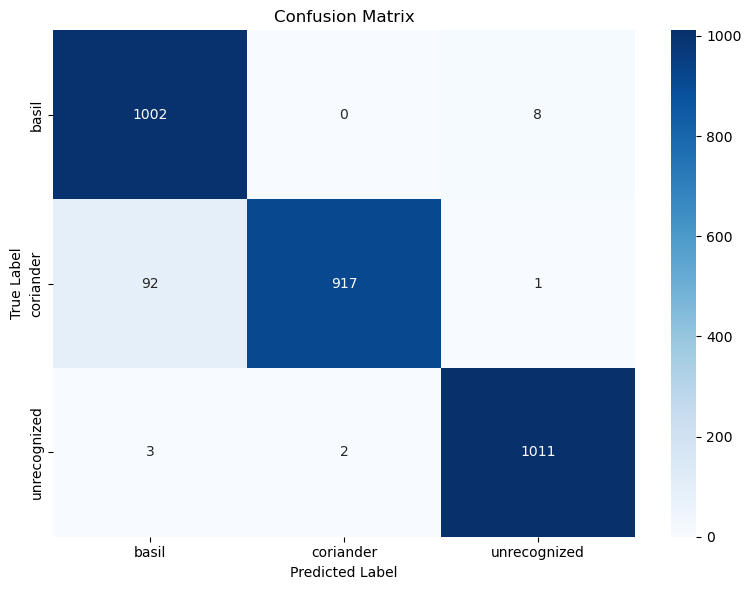


  OVERALL ACCURACY OF THE MODEL: 96.5086%  



In [51]:
# Results
class_names = train_set.classes  # or your custom list

# Calculate classification report and confusion matrix
report = classification_report(all_labels, all_preds, target_names=class_names)
cm = confusion_matrix(all_labels, all_preds)

# Calculate overall accuracy
accuracy = accuracy_score(all_labels, all_preds)

print("Classification Report:\n")
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print overall accuracy with enhanced formatting
print("\n" + "="*50)
print(f"  OVERALL ACCURACY OF THE MODEL: {accuracy:.4%}  ")  # Percentage with 4 decimals
print("="*50 + "\n")

<Figure size 640x480 with 0 Axes>

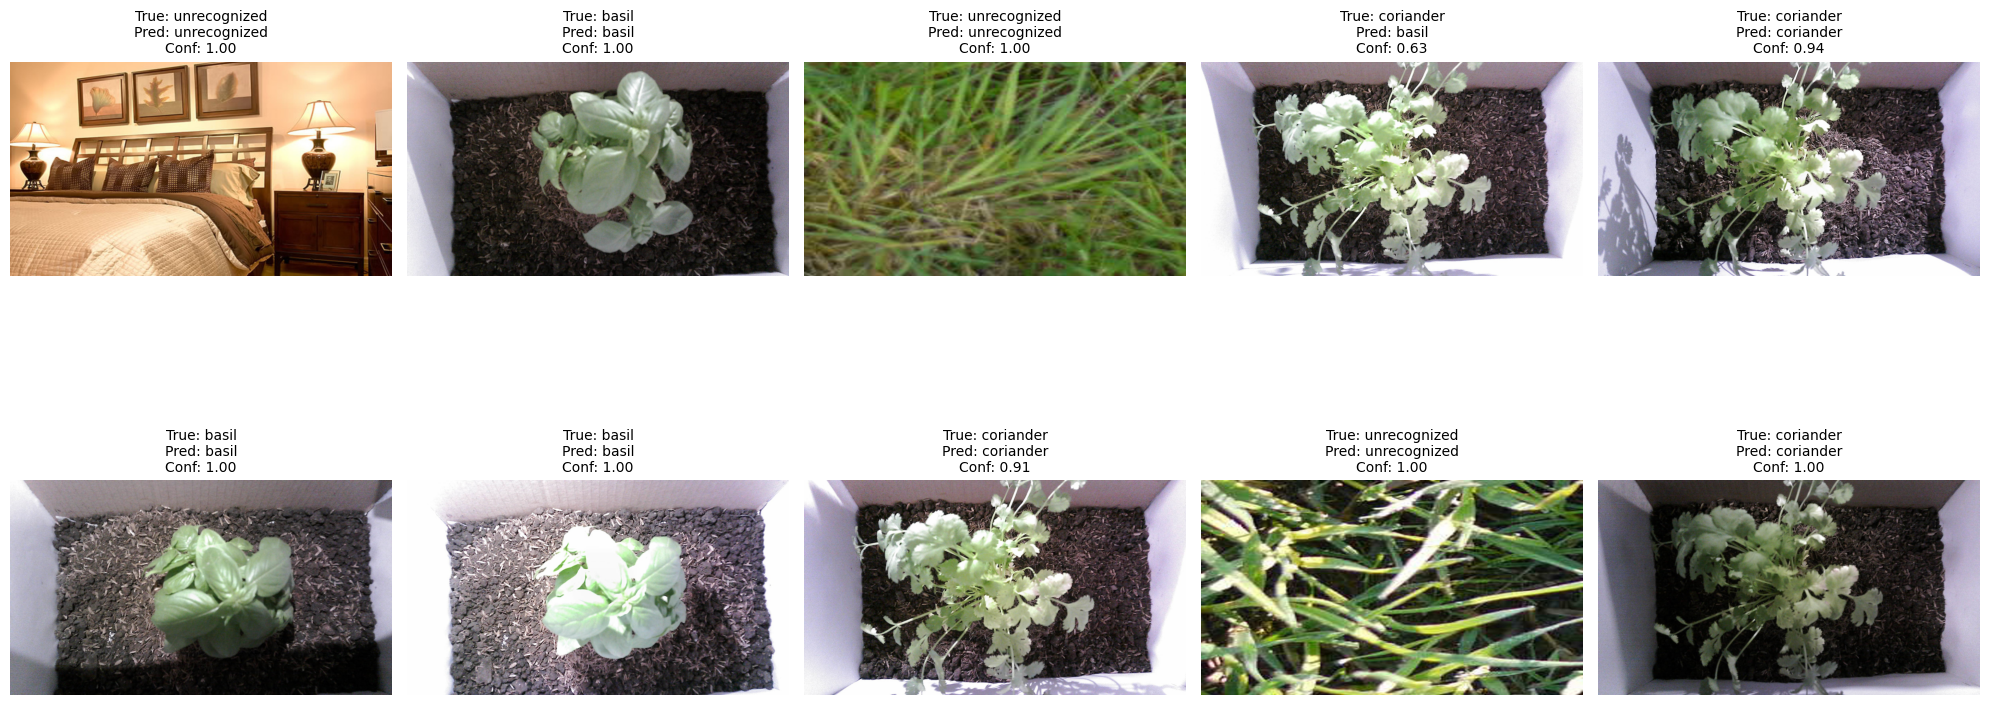

In [87]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_random_raw_samples(test_loader, all_labels, all_preds, all_probs, class_names, num_samples=10):
    dataset = test_loader.dataset
    
    indices = random.sample(range(len(dataset)), num_samples)
    n_rows = 2
    n_cols = (num_samples + 1) // 2
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 5 * n_rows))
    axs = axs.flatten()
    
    for i, ax in enumerate(axs):
        if i < num_samples:
            idx = indices[i]
            img_path, _ = dataset.samples[idx]
            raw_image = Image.open(img_path).convert("RGB")
            
            true_label = class_names[all_labels[idx]]
            pred_label = class_names[all_preds[idx]]
            confidence = all_probs[idx][all_preds[idx]]
            
            ax.imshow(raw_image)
            ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show() 

show_random_raw_samples(test, all_labels, all_preds, all_probs, class_names, num_samples=10)